In [1]:
import sys
sys.path.insert(1,"../src")
import tensorflow as tf
import keras as tfk
tfkl = tfk.layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import util
import GA_util
import actmax
print('loaded')

loaded


2025-03-19 17:53:11.980932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-19 17:53:11.980977: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Ultra


2025-03-19 17:53:12.603376: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-19 17:53:12.603621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-19 17:53:12.849316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-19 17:53:12.957269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-19 17:53:13.092542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


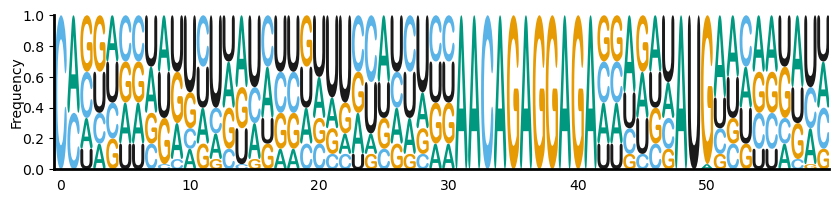

In [2]:
latent_dim = 128

generator = tf.keras.models.load_model('../models/toehold_generator_2023-04-21')
tmp = generator(np.random.normal(size=(30,128)))
util.plot_logo(tmp[:,:,:,0])

In [3]:
predictor = tfk.models.load_model('models/big_screen_non_linear_on_off_74')

mod = actmax.ActMaxModelAptaswitch(generator,predictor)

latent_dim=128
random_latent_vectors = tf.expand_dims(tf.cast(np.random.normal(size=(latent_dim,)),'float32'),axis=0)

# mod(random_latent_vectors)

test = mod.get_aptaswitch(random_latent_vectors)

print(GA_util.unencode(test[0,:,:]))

print(GA_util.unencode(mod.get_triggers(random_latent_vectors)[0,:,:]))

GCGCTAATACGACTCACTATAGGGAACACCTCAATTTCTTGGGTAATTTCTTGGAACAGAGGAGACCAAGAATGTACCCAAGAGTCGAGTAGAGTGTGGGCTCAGATTCGTCTGAGACGGTCGGGTCCTCTTGGGAA
CAAGAAATTACCCAAGAAATTGAGGTGTTG


In [4]:
cluster = [93]

In [6]:
import actmax
import time


vecs_save = []
opt_df_save = []

for i in cluster:
    

    print(i)
    # print(cluster_2[i])
    time_start = time.time()
    predictor = tfk.models.load_model('models/big_screen_non_linear_on_off_%s'%i)

    apta_mod = actmax.ActMaxModelAptaswitch(generator,predictor)

    vecs,opt_df = actmax.run_gan_opt_mult_seqs(apta_mod,nseqs=100,output='on',n_steps=600,step_size=0.1,verbose=False)

    vecs_save.append(vecs)
    opt_df_save.append(opt_df)
    print(np.mean(opt_df[['Delta']]))
    print('Elapsed Time: ',time.time() - time_start)
    print('\n')

93
Delta   -0.227601
dtype: float64
Elapsed Time:  16.22474503517151




/opt/homebrew/Caskroom/miniforge/base/envs/GARDN/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [7]:
# np.save('stat_tests/final_vecs_93_4_25_long.npy',vecs_save)

# np.save('stat_tests/final_dfs_93_4_25_long.npy',opt_df_save) 

In [8]:
vecs_save = np.load('stat_tests/final_vecs_93_4_25.npy')
opt_df_save = np.load('stat_tests/final_dfs_93_4_25.npy',allow_pickle=True)

In [9]:
apta_mod = actmax.ActMaxModelAptaswitch(generator,predictor)

-0.1329775160551071


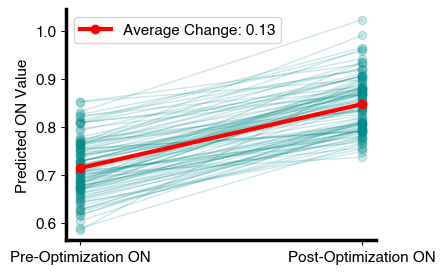

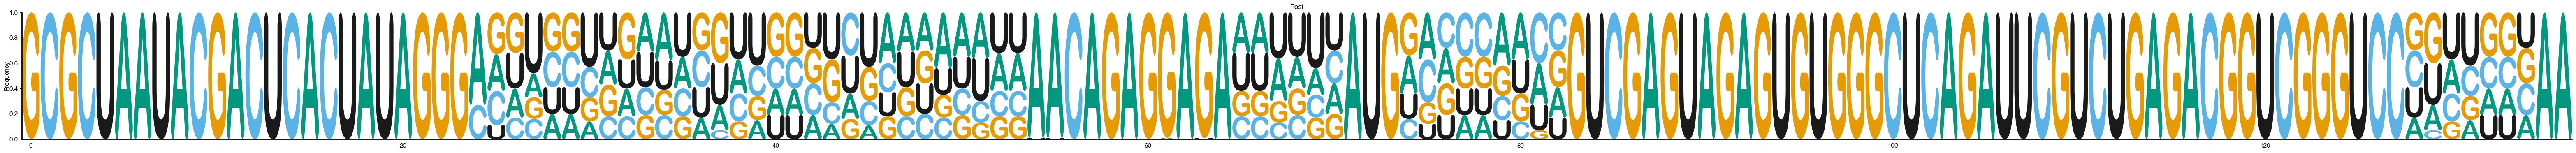

In [10]:
for i in range(len(vecs_save)):
    # print(cluster_2[i])
    tick_1 = 0.25
    tick_2 = 0.75

    df = opt_df_save[i]
    df = pd.DataFrame(df)
    df.columns = ['Pre_Optimized_Value','Post_Optimized_Value','Target_Value','Delta']
    df['Post_Optimized_Value'] = df['Post_Optimized_Value'].astype(float)
    # df = pd.read_csv('sequences/rbs_gardn_sandstorm_10_10_23.csv')

    pre_mean = np.mean(df['Pre_Optimized_Value'])
    post_mean = np.mean(df['Post_Optimized_Value'])
    print(np.mean(df['Delta']))

    plt.figure(figsize=(4,3))
    plt.rcParams.update({'font.size': 11,'font.family':'Helvetica'})
    plt.xticks(ticks=[tick_1,tick_2], labels=['Pre-Optimization ON','Post-Optimization ON'])
    plt.subplot().spines['right'].set_visible(False)
    plt.subplot().spines['top'].set_visible(False)
    plt.subplot().spines['left'].set_linewidth(2.5)
    plt.subplot().spines['bottom'].set_linewidth(2.5)
    plt.ylabel('Predicted ON Value')
    # plt.xlim([0,1])
    # plt.ylim([0,1])
    # plt.title('ON Value Optimization Results')
    for j in range(df.shape[0]):
        plt.plot([tick_1,tick_2],[df.iloc[j,0],df.iloc[j,1]],color='darkcyan',alpha=0.2,marker='o',linewidth=1)

    plt.plot([tick_1,tick_2],[pre_mean,post_mean],color='red',alpha=1,marker='o',linewidth=3,label='Average Change: %.2f'%(post_mean-pre_mean))
    plt.legend()
    plt.show()

    seqs_post = apta_mod.get_aptaswitch(vecs_save[i][:,:,1])
    
    # for k in range(seqs_post.shape[0]):
    #     print(GA_util.unencode(seqs_post[k,:,:]))
    # print(cluster_2[i])
    util.plot_logo(seqs_post,figsize=[80,4],title='Post')
    plt.show()
    print('\n')


(12, 4, 137)


























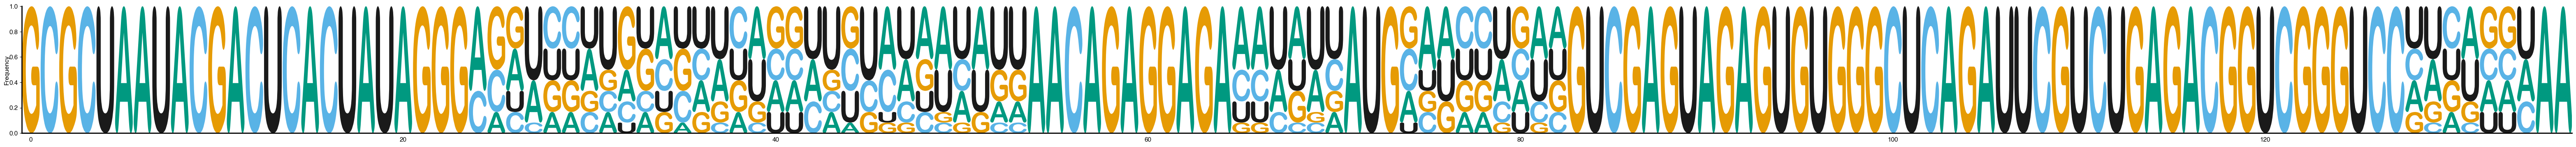

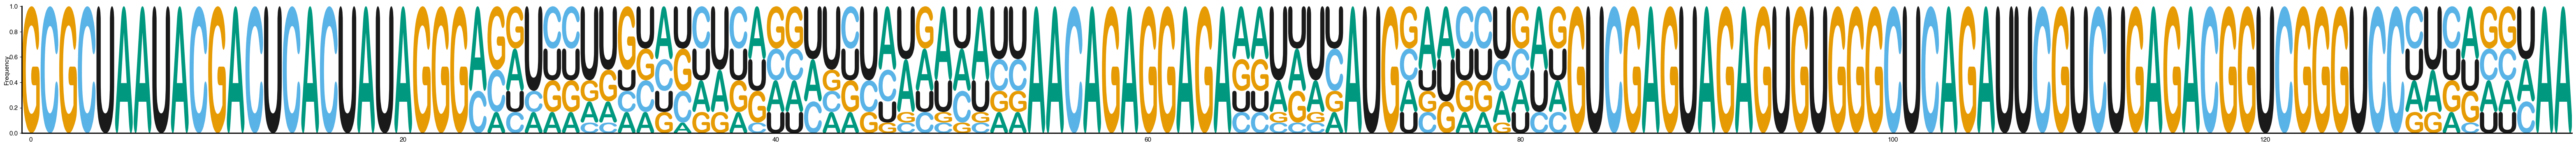

In [12]:
#Save each of the sequences for 93
pre_seq_save = []
pre_trigger_save = []
pre_name_save = []

post_seq_save = []
post_trigger_save = []
post_name_save = []

for idx in range(1):
    
    df = opt_df_save[i]
    df = pd.DataFrame(df)
    df.columns = ['Pre_Optimized_Value','Post_Optimized_Value','Target_Value','Delta']
    df['Post_Optimized_Value'] = df['Post_Optimized_Value'].astype(float)
    df['Delta'] = df['Delta'].astype(float)
    
    vecs_to_grab = list(df.nlargest(12,'Delta').index)
    # vecs_to_grab = list(df.nsmallest(10,'Pre_Optimized_Value').index)

    vectors_this_target = vecs_save[idx]

    pre_vecs = vectors_this_target[vecs_to_grab,:,0]
    post_vecs = vectors_this_target[vecs_to_grab,:,1]

    pre_seqs = apta_mod.get_aptaswitch(pre_vecs)
    pre_triggers = apta_mod.get_triggers(pre_vecs)
    
    post_seqs = apta_mod.get_aptaswitch(post_vecs)
    post_triggers = apta_mod.get_triggers(post_vecs)
    
    util.plot_logo(pre_seqs,figsize=[80,4])
    util.plot_logo(post_seqs,figsize=[80,4])
    
    print(pre_seqs.shape)
    
    for j in range(pre_seqs.shape[0]):
        
        name = 'pre_%s_%s'%(cluster[idx],j)
        
        tmp_seq = GA_util.unencode(pre_seqs[j,:,:])
        tmp_trigger = GA_util.unencode(pre_triggers[j,:,:])
        # print(GA_util.unencode(tmp_seq))
        # print(GA_util.unencode(tmp_trigger))
        
        pre_seq_save.append(tmp_seq)
        pre_trigger_save.append(tmp_trigger)
        pre_name_save.append(name)
        
        print('\n')
        
    for k in range(post_seqs.shape[0]):
        name = 'post_%s_%s'%(cluster[idx],k)
        
        tmp_seq_post = GA_util.unencode(post_seqs[k,:,:])
        tmp_trigger_post = GA_util.unencode(post_triggers[k,:,:])
        
        # print(GA_util.unencode(tmp_seq_post))
        # print(GA_util.unencode(tmp_trigger_post))
        
        post_seq_save.append(tmp_seq_post)
        post_trigger_save.append(tmp_trigger_post)
        post_name_save.append(name)

In [13]:
pre_opt_exp = pd.DataFrame({'Name':pre_name_save,'Sequence':pre_seq_save,'Trigger':pre_trigger_save})
# pre_opt_exp.to_csv('data/final_pre_optimized_aptaswitches_4_29.csv')

In [14]:
post_opt_exp = pd.DataFrame({'Name':post_name_save,'Sequence':post_seq_save,'Trigger':post_trigger_save})
# post_opt_exp.to_csv('data/final_post_optimized_aptaswitches_4_29.csv')

In [15]:
master = pd.concat((pre_opt_exp,post_opt_exp))

In [16]:
master.shape

(24, 3)

In [17]:
# master=pd.read_excel('data/GARDN_Aptaswitch_Final.xlsx')

# for i in range(master.shape[0]):
#     print(master.iloc[i,:])

In [18]:
master

,Name,Sequence,Trigger
0,pre_93_0,GCGCTAATACGACTCACTATAGGGAGGACCTTGTGCAACATTTAGT...,ATGTAAAACTAAATGTTGCACAAGGTCCTG
1,pre_93_1,GCGCTAATACGACTCACTATAGGGAACTAAGGAAATTGTGAACTGC...,TCAAAGTGCAGTTCACAATTTCCTTAGTTG
2,pre_93_2,GCGCTAATACGACTCACTATAGGGCCGTTTTTGGTCTACATTCTCT...,ATACTAGAGAGAATGTAGACCAAAAACGGG
3,pre_93_3,GCGCTAATACGACTCACTATAGGGACAAAAATGGACTGCTGGAGGG...,AAGTTGCCCCTCCAGCAGTCCATTTTTGTG
4,pre_93_4,GCGCTAATACGACTCACTATAGGGAGGTCCACATCTGACCCCTCAG...,CAAGCATCTGAGGGGTCAGATGTGGACCTG
5,pre_93_5,GCGCTAATACGACTCACTATAGGGAATATTGGGCAGCCAGAATCGC...,TACAGCTGCGATTCTGGCTGCCCAATATTG
6,pre_93_6,GCGCTAATACGACTCACTATAGGGCCACCCATCTCGATGTCCATCT...,GTTTTTGAGATGGACATCGAGATGGGTGGG
7,pre_93_7,GCGCTAATACGACTCACTATAGGGAGGTGGCTGCAATAATCCTTTC...,ATATGATGAAAGGATTATTGCAGCCACCTG
8,pre_93_8,GCGCTAATACGACTCACTATAGGGCCATGGCATTCTATTAGGAGTT...,CTGATTGAACTCCTAATAGAATGCCATGGG
9,pre_93_9,GCGCTAATACGACTCACTATAGGGAGATCCATGGAGCTGAGGCTCT...,CCTTTTTAGAGCCTCAGCTCCATGGATCTG


In [19]:
rev_save = []
for i,seq in enumerate(master['Sequence']):
    
    rev = GA_util.revcompstr(seq)
    
    rev_save.append(rev)

In [20]:
master.shape

(24, 3)

In [21]:
master['Reverse'] = rev_save

# master.to_csv('data/GARDN_Aptaswitch_follow_up_3_9_24.csv')

In [22]:
master

,Name,Sequence,Trigger,Reverse
0,pre_93_0,GCGCTAATACGACTCACTATAGGGAGGACCTTGTGCAACATTTAGT...,ATGTAAAACTAAATGTTGCACAAGGTCCTG,TTAAATGTTGGACCCGACCGTCTCAGACGAATCTGAGCCCACACTC...
1,pre_93_1,GCGCTAATACGACTCACTATAGGGAACTAAGGAAATTGTGAACTGC...,TCAAAGTGCAGTTCACAATTTCCTTAGTTG,TTGTTCACAGGACCCGACCGTCTCAGACGAATCTGAGCCCACACTC...
2,pre_93_2,GCGCTAATACGACTCACTATAGGGCCGTTTTTGGTCTACATTCTCT...,ATACTAGAGAGAATGTAGACCAAAAACGGG,TTGAATGTAGGACCCGACCGTCTCAGACGAATCTGAGCCCACACTC...
3,pre_93_3,GCGCTAATACGACTCACTATAGGGACAAAAATGGACTGCTGGAGGG...,AAGTTGCCCCTCCAGCAGTCCATTTTTGTG,TTTCCAGCAGGACCCGACCGTCTCAGACGAATCTGAGCCCACACTC...
4,pre_93_4,GCGCTAATACGACTCACTATAGGGAGGTCCACATCTGACCCCTCAG...,CAAGCATCTGAGGGGTCAGATGTGGACCTG,TTAGGGGTCGGACCCGACCGTCTCAGACGAATCTGAGCCCACACTC...
5,pre_93_5,GCGCTAATACGACTCACTATAGGGAATATTGGGCAGCCAGAATCGC...,TACAGCTGCGATTCTGGCTGCCCAATATTG,TTATTCTGGGGACCCGACCGTCTCAGACGAATCTGAGCCCACACTC...
6,pre_93_6,GCGCTAATACGACTCACTATAGGGCCACCCATCTCGATGTCCATCT...,GTTTTTGAGATGGACATCGAGATGGGTGGG,TTTGGACATGGACCCGACCGTCTCAGACGAATCTGAGCCCACACTC...
7,pre_93_7,GCGCTAATACGACTCACTATAGGGAGGTGGCTGCAATAATCCTTTC...,ATATGATGAAAGGATTATTGCAGCCACCTG,TTAGGATTAGGACCCGACCGTCTCAGACGAATCTGAGCCCACACTC...
8,pre_93_8,GCGCTAATACGACTCACTATAGGGCCATGGCATTCTATTAGGAGTT...,CTGATTGAACTCCTAATAGAATGCCATGGG,TTTCCTAATGGACCCGACCGTCTCAGACGAATCTGAGCCCACACTC...
9,pre_93_9,GCGCTAATACGACTCACTATAGGGAGATCCATGGAGCTGAGGCTCT...,CCTTTTTAGAGCCTCAGCTCCATGGATCTG,TTGCCTCAGGGACCCGACCGTCTCAGACGAATCTGAGCCCACACTC...
